Optimizando colsample_bynode para: Scale Pos Weight...
Optimizando colsample_bynode para: SMOTE + Tomek...
Optimizando colsample_bynode para: SMOTE + ENN...
Optimizando colsample_bynode para: NearMiss...
Optimizando colsample_bynode para: ADASYN...


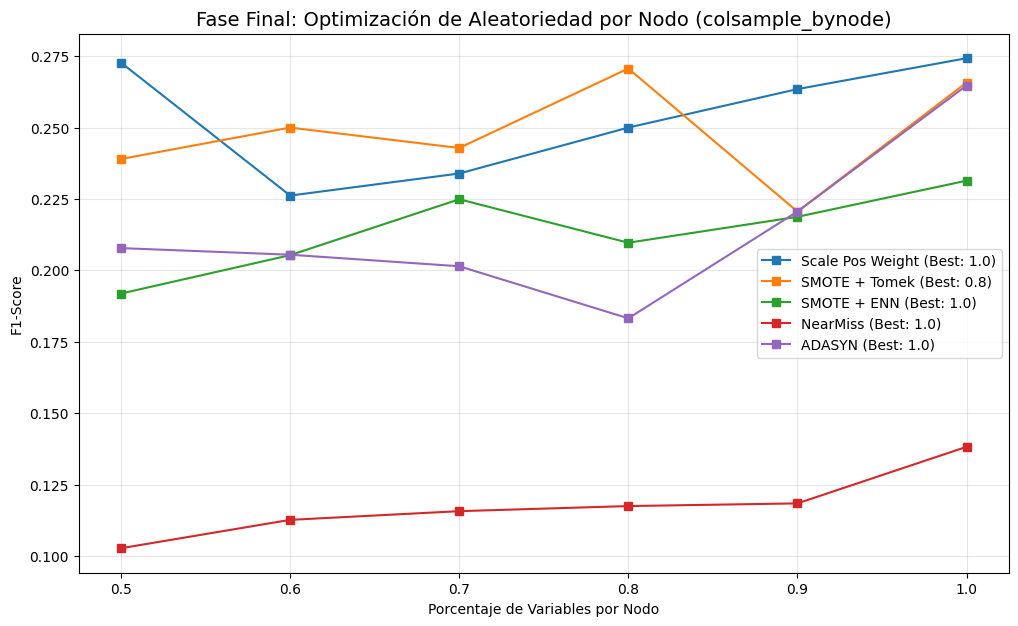


TÉCNICA              | BEST COLNODE    | MAX F1 FINAL
----------------------------------------------------------------------
Scale Pos Weight     | 1.0             | 0.2743
SMOTE + Tomek        | 0.8             | 0.2707
SMOTE + ENN          | 1.0             | 0.2314
NearMiss             | 1.0             | 0.1382
ADASYN               | 1.0             | 0.2647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. PREPARACIÓN DE DATOS
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. CONFIGURACIÓN MAESTRA FINAL (Incluye SPW ideal por técnica)
# Estructura: {Nombre: (Sampler, n_est, lr, depth, child_w, gamma, subsample, col_tree, spw)}
config_fase_final = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1, 0, 0.9, 1.0, 19.4),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3, 0.1, 1.0, 1.0, 1),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1, 0, 0.8, 1.0, 1),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1, 0, 1.0, 1.0, 1),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1, 0, 1.0, 1.0, 1)
}

colnode_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
final_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n, lr, d, w, g, sub, col_t, spw) in config_fase_final.items():
    node_f1 = []
    
    # Aplicar sampler si corresponde
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
        
    print(f"Optimizando colsample_bynode para: {nombre}...")
    
    for cn in colnode_range:
        model = XGBClassifier(
            n_estimators=n,
            learning_rate=lr,
            max_depth=d,
            min_child_weight=w,
            gamma=g,
            subsample=sub,
            colsample_bytree=col_t,
            colsample_bynode=cn,     # Parámetro final a optimizar
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        node_f1.append(f1_score(y_test, y_pred))
    
    max_f1 = max(node_f1)
    best_cn = colnode_range[node_f1.index(max_f1)]
    final_results.append({'Técnica': nombre, 'Best Colnode': best_cn, 'Max F1': max_f1})
    
    plt.plot(colnode_range, node_f1, marker='s', label=f"{nombre} (Best: {best_cn})")

plt.title('Fase Final: Optimización de Aleatoriedad por Nodo (colsample_bynode)', fontsize=14)
plt.xlabel('Porcentaje de Variables por Nodo')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. TABLA DEFINITIVA DE CONFIGURACIÓN
print("\n" + "="*70)
print(f"{'TÉCNICA':<20} | {'BEST COLNODE':<15} | {'MAX F1 FINAL':<12}")
print("-" * 70)
for r in final_results:
    print(f"{r['Técnica']:<20} | {r['Best Colnode']:<15} | {r['Max F1']:.4f}")
print("="*70)